## 0.  Import Libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import datetime
import zipfile
import glob
import os
import time
import shutil

from IPython.display import clear_output

## 1. Unzip Directories

In [2]:
# general path
path_general = fr"data/TOT_PREC/era5land"

# files of zips
zip_files = glob.glob(fr"{path_general}/*zip*")

In [3]:
for zip_file in zip_files:
    
    # find the name isolated from the path
    last_slash = zip_files[0].rfind('/')
    name_save = zip_file[last_slash+1:-11]
    
    with zipfile.ZipFile(zip_file,"r") as zip_ref:
        zip_ref.extractall(fr"{path_general}/{name_save}")
        
    time.sleep(2)
    # rename the data
    os.rename(fr"{path_general}/{name_save}/data.nc", fr"{path_general}/{name_save}/{name_save}.nc")
    
    # move data to parent dir
    shutil.move(fr"{path_general}/{name_save}/{name_save}.nc", fr"{path_general}/{name_save}.nc")
        
    print(fr'done with: {name_save}')

done with: era5land_TOT_PREC_01_1hr_1985
done with: era5land_TOT_PREC_01_1hr_1986
done with: era5land_TOT_PREC_01_1hr_1987
done with: era5land_TOT_PREC_01_1hr_1988
done with: era5land_TOT_PREC_01_1hr_1989
done with: era5land_TOT_PREC_01_1hr_1990
done with: era5land_TOT_PREC_01_1hr_1991
done with: era5land_TOT_PREC_01_1hr_1992
done with: era5land_TOT_PREC_01_1hr_1993
done with: era5land_TOT_PREC_01_1hr_1994
done with: era5land_TOT_PREC_01_1hr_1995
done with: era5land_TOT_PREC_01_1hr_1996
done with: era5land_TOT_PREC_01_1hr_1997
done with: era5land_TOT_PREC_01_1hr_1998
done with: era5land_TOT_PREC_01_1hr_1999
done with: era5land_TOT_PREC_01_1hr_2000
done with: era5land_TOT_PREC_01_1hr_2001
done with: era5land_TOT_PREC_01_1hr_2002
done with: era5land_TOT_PREC_01_1hr_2003
done with: era5land_TOT_PREC_01_1hr_2004
done with: era5land_TOT_PREC_01_1hr_2005
done with: era5land_TOT_PREC_02_1hr_1985
done with: era5land_TOT_PREC_02_1hr_1986
done with: era5land_TOT_PREC_02_1hr_1987
done with: era5l

In [50]:
data_adjust

<xarray.DataArray 'tp' (time: 2160, latitude: 101, longitude: 231)>
dask.array<setitem, shape=(2160, 101, 231), dtype=float32, chunksize=(744, 101, 231), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 24.0 24.1 24.2 24.3 ... 46.7 46.8 46.9 47.0
  * latitude   (latitude) float32 44.0 43.9 43.8 43.7 ... 34.3 34.2 34.1 34.0
  * time       (time) datetime64[ns] 1985-01-01 ... 1985-12-31T23:00:00

## 2. Merge Data and Check Adjustment

dont forget, you first merge each year individually and save, then you will merge all years together

In [3]:
# files of zips
nc_files = glob.glob(fr"{path_general}/*nc*")

In [4]:
# create nan mask array
sample_data = xr.open_dataset(fr'{path_general}/era5land_TOT_PREC_01_1hr_1985.nc')['tp'][0]
era5land_nans = sample_data.isnull()

In [5]:
# CHANGE THESE: Options: DJF, JJA ##########3
season = 'JJA'

# month numbers for seasons
if season == 'DJF':
    first_month = '01'
    second_month = '02'
    third_month = '12'
    
elif season == 'JJA':
    first_month = '06'
    second_month = '07'
    third_month = '08'    
    
years = np.arange(1985, 2006, dtype=int)

for year in years:
    
    # find seasonal data for each year
    _files = list(filter(lambda file: (fr'_{first_month}_' in file) or 
                                      (fr'_{second_month}_' in file) or 
                                      (fr'_{third_month}_' in file), 
                         nc_files
                        )
                 )

    single_file = list(filter(lambda file: (fr'_{year}' in file), _files))
    single_file

    # open data
    data = xr.open_mfdataset(single_file)['tp'] # keep it meters unit

    # get times and year list
    times = data['time'].values

    # for every data do this regardless of the season
    data[0] = data[1]

    # only for winter do this
    if season == 'DJF':

        # find where 12. month starts
        winter_december_idx = np.argwhere(times == np.datetime64(fr'{year}-12-01T00:00:00.000000000')).flatten()[0]

        # data[12.ay'ın ilk gününün 00 UTC si] = data[12.ay'ın ilk gününün 01 UTC si]
        data[winter_december_idx] = data[winter_december_idx+1]
    
    # NOW ADJUST DATA
    # do not change base data
    data_adjust = data.copy(deep=True)

    for i, h in enumerate(data['time'].dt.hour):

        # integer h
        h_int = int(h.values)

        # do not change initial data hour
        if i == 0:
            continue

        # do not change initial data hour of 12. month for winter
        if season == 'DJF':
            if i == winter_december_idx: # 12.ay'ın ilk gününün 00 UTC si
                continue # we have already checked and changed it above!!

        # 01 UTC is clear
        if h_int == 1:
            continue

        # other than 01 UTC
        else:
            data_adjust[i] = data[i] - data[i-1]
            
    # negative values to zero (increases file size?? canceled for now)
    #data_adjust = data_adjust.where((era5land_nans==1) | (data_adjust>=0), 0)
    
    # save data yearly
    data_adjust.to_netcdf(fr'{path_general}/era5land_TOT_PREC_{season}_1hr_{year}.nc')
            
    # close data
    data.close()
    data_adjust.close()
    
    # inform
    print(fr'done with: {year} {season}')
    clear_output(wait=True)

done with: 2005 JJA


In [19]:
data_adjust

<xarray.DataArray 'tp' (time: 2160, latitude: 101, longitude: 231)>
dask.array<where, shape=(2160, 101, 231), dtype=float32, chunksize=(744, 101, 231), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 24.0 24.1 24.2 24.3 ... 46.7 46.8 46.9 47.0
  * latitude   (latitude) float32 44.0 43.9 43.8 43.7 ... 34.3 34.2 34.1 34.0
  * time       (time) datetime64[ns] 1987-01-01 ... 1987-12-31T23:00:00
Attributes:
    units:      m
    long_name:  Total precipitation

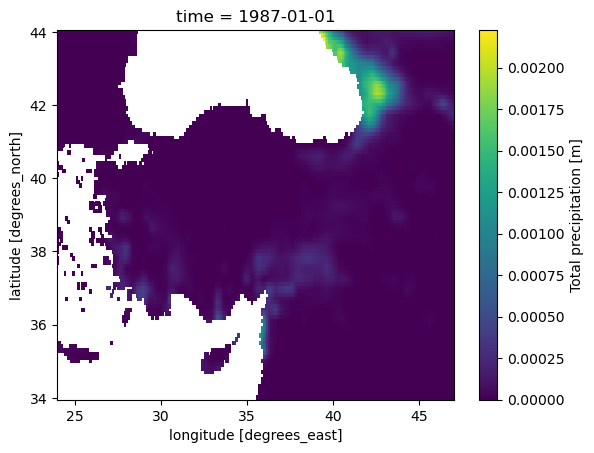

In [18]:
data_adjust[0].plot()

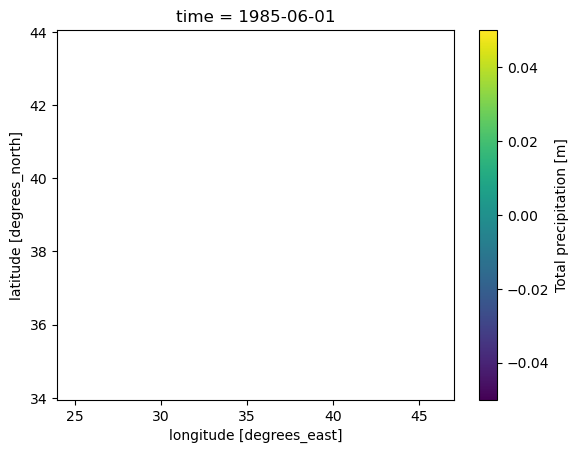

In [30]:
data_adjust.where(data_adjust.isnull())[0].plot()

In [33]:
era5land_nans = data_adjust.isnull()[0]

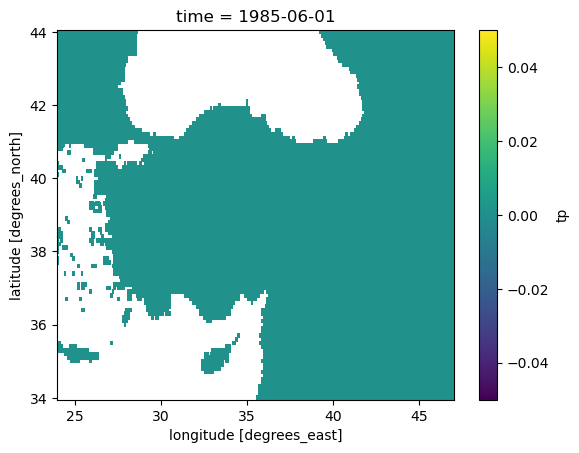

In [38]:
era5land_nans.where(era5land_nans==0).plot()

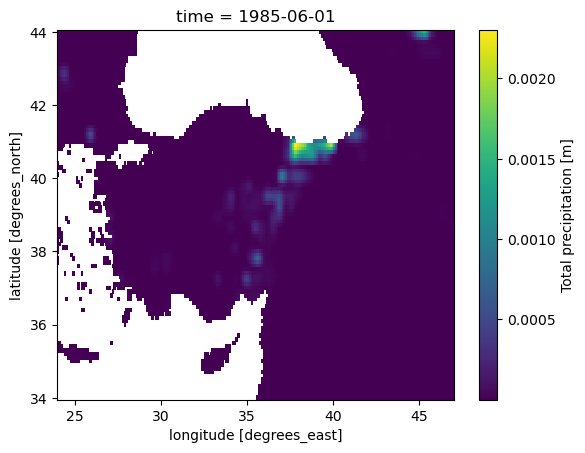

In [47]:
era5land_nans = data_adjust.isnull()[0]
data_adjust = data_adjust.where((era5land_nans==1) | (data_adjust>=0), 0)

In [5]:
data_adjust

<xarray.DataArray 'tp' (time: 2208, latitude: 101, longitude: 231)>
dask.array<where, shape=(2208, 101, 231), dtype=float32, chunksize=(744, 101, 231), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 24.0 24.1 24.2 24.3 ... 46.7 46.8 46.9 47.0
  * latitude   (latitude) float32 44.0 43.9 43.8 43.7 ... 34.3 34.2 34.1 34.0
  * time       (time) datetime64[ns] 1986-06-01 ... 1986-08-31T23:00:00
Attributes:
    units:      m
    long_name:  Total precipitation

## 3. Check Adjustment wrt ERA5

In [ ]:
era5land = xr.open_dataset(fr'{path_general}/era5land_TOT_PREC_{season}_1hr_1985.nc')

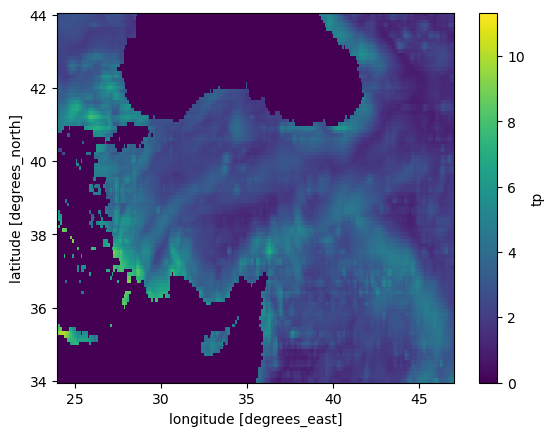

In [ ]:
(era5land['tp'].sum(dim='time')*1e3).plot()

In [ ]:
era5 = xr.open_dataset(fr'/mnt/d/JupyterLab/Yuksek_Lisans/msc_thesis_data/era5/era5_TOT_PREC_{season}_1hr_1985_2005.nc')

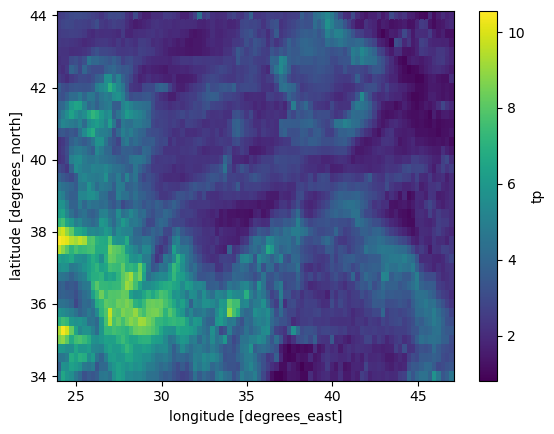

In [ ]:
(era5.sel(time='1985').max(dim='time')['tp']*1e3).plot()